Imports and file paths

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

root = Path('K://Josh/Argus')

target_path = Path(f'{root}/Site_Data/London/Reader_000006')
day1 = Path(f'{target_path}/GMR_results_000006_20240601_000012.csv')
day2 = Path(f'{target_path}/GMR_results_000006_20240602_000021.csv')


Use pandas to read csv files with headers.

In [56]:
day1_data = pd.read_csv(
    filepath_or_buffer=day1,
    sep=',',
    skiprows=3)
day2_data = pd.read_csv(
    filepath_or_buffer=day2,
    sep=',',
    skiprows=3)

convert time stamps from file

In [57]:
timedate_stamps1 = day1_data['# Date']
time_obj1 = [datetime.strptime(date_str, "%Y%m%d_%H%M%S") for date_str in timedate_stamps1]
timestamps1 = [obj.timestamp() for obj in time_obj1]
corrected_time1 = [time - timestamps1[0] for time in timestamps1]

timedate_stamps2 = day2_data['# Date']
time_obj2 = [datetime.strptime(date_str, "%Y%m%d_%H%M%S") for date_str in timedate_stamps2]
timestamps2 = [obj.timestamp() for obj in time_obj2]
corrected_time2 = [time - timestamps2[0] + corrected_time1[-1] for time in timestamps2]

Concatenate data from both days.

In [58]:
total_time = np.concatenate((corrected_time1, corrected_time2))
temperature = np.concatenate((day1_data['temperature'], day2_data['temperature']))
sensor2 = np.concatenate((day1_data['sensor2'], day2_data['sensor2']))
sensor3 = np.concatenate((day1_data['sensor3'], day2_data['sensor3']))
temp2 = np.concatenate((day1_data['temp2'], day2_data['temp2']))
temp3 = np.concatenate((day1_data['temp3'], day2_data['temp3']))

Plot data to show the raw data.

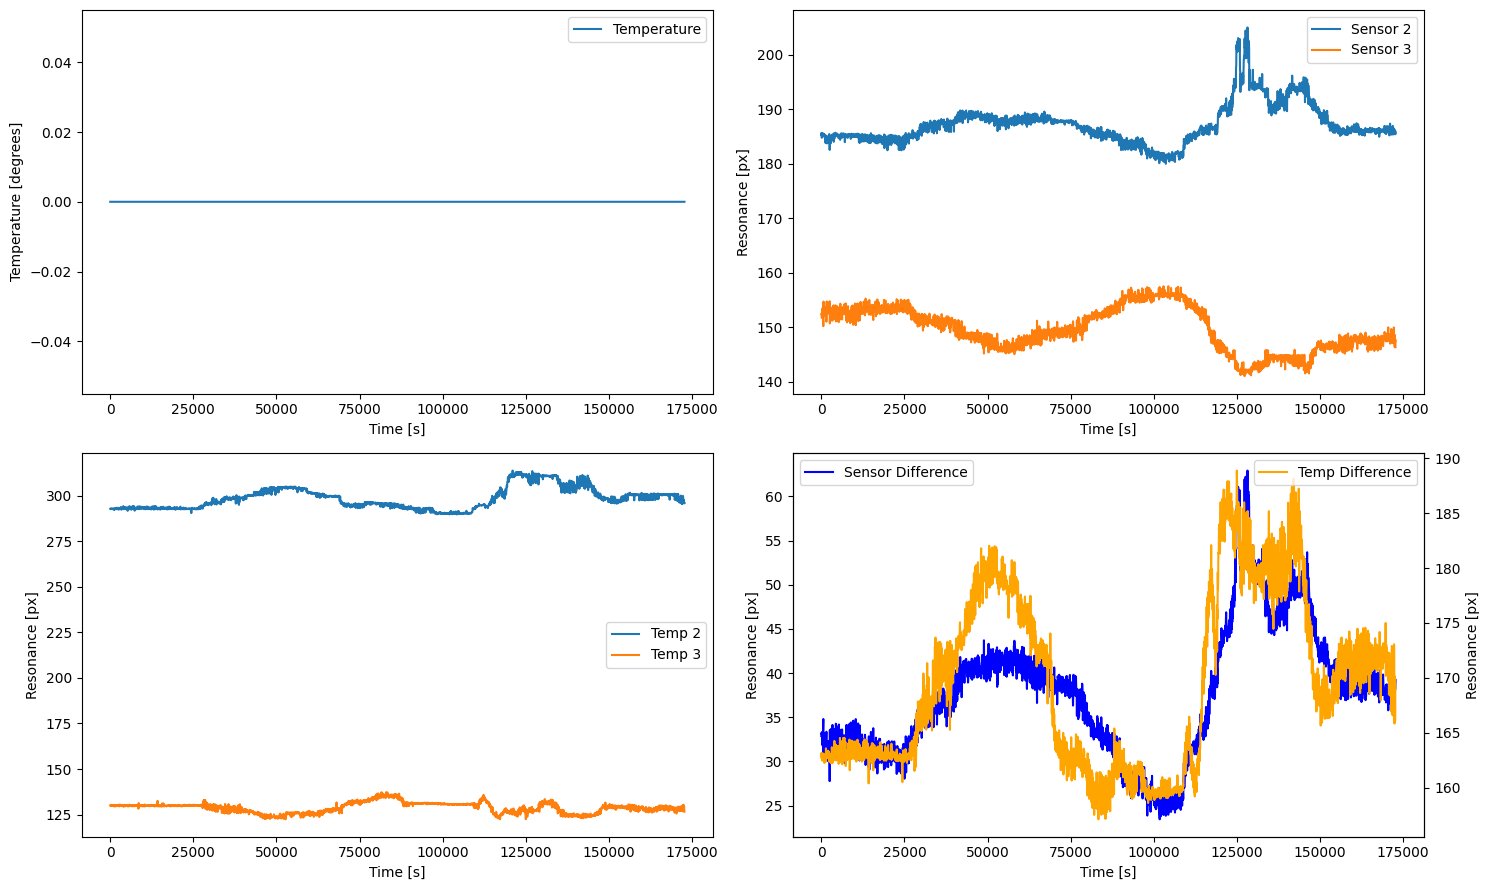

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=[15, 9])
ax1.plot(total_time, temperature, label='Temperature')
ax1.legend(loc=0)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [degrees]')
ax2.plot(total_time, sensor2, label='Sensor 2')
ax2.plot(total_time, sensor3, label='Sensor 3')
ax2.legend(loc=0)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Resonance [px]')
ax3.plot(total_time, temp2, label='Temp 2')
ax3.plot(total_time, temp3, label='Temp 3')
ax3.legend(loc=0)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Resonance [px]')
ax5 = ax4.twinx()
ax4.plot(total_time, sensor2-sensor3, 'b', label='Sensor Difference')
ax5.plot(total_time, temp2-temp3, 'orange', label='Temp Difference')
ax4.legend(loc=0)
ax5.legend(loc=1)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Resonance [px]')
ax5.set_ylabel('Resonance [px]')
fig.tight_layout()
plt.show()

Plot the first day of data as temperature (x) and sensor (y) to get the fit. Can try by taking the average or by taking one from each sensor, basically either it's a symmetrical bow tie or not.

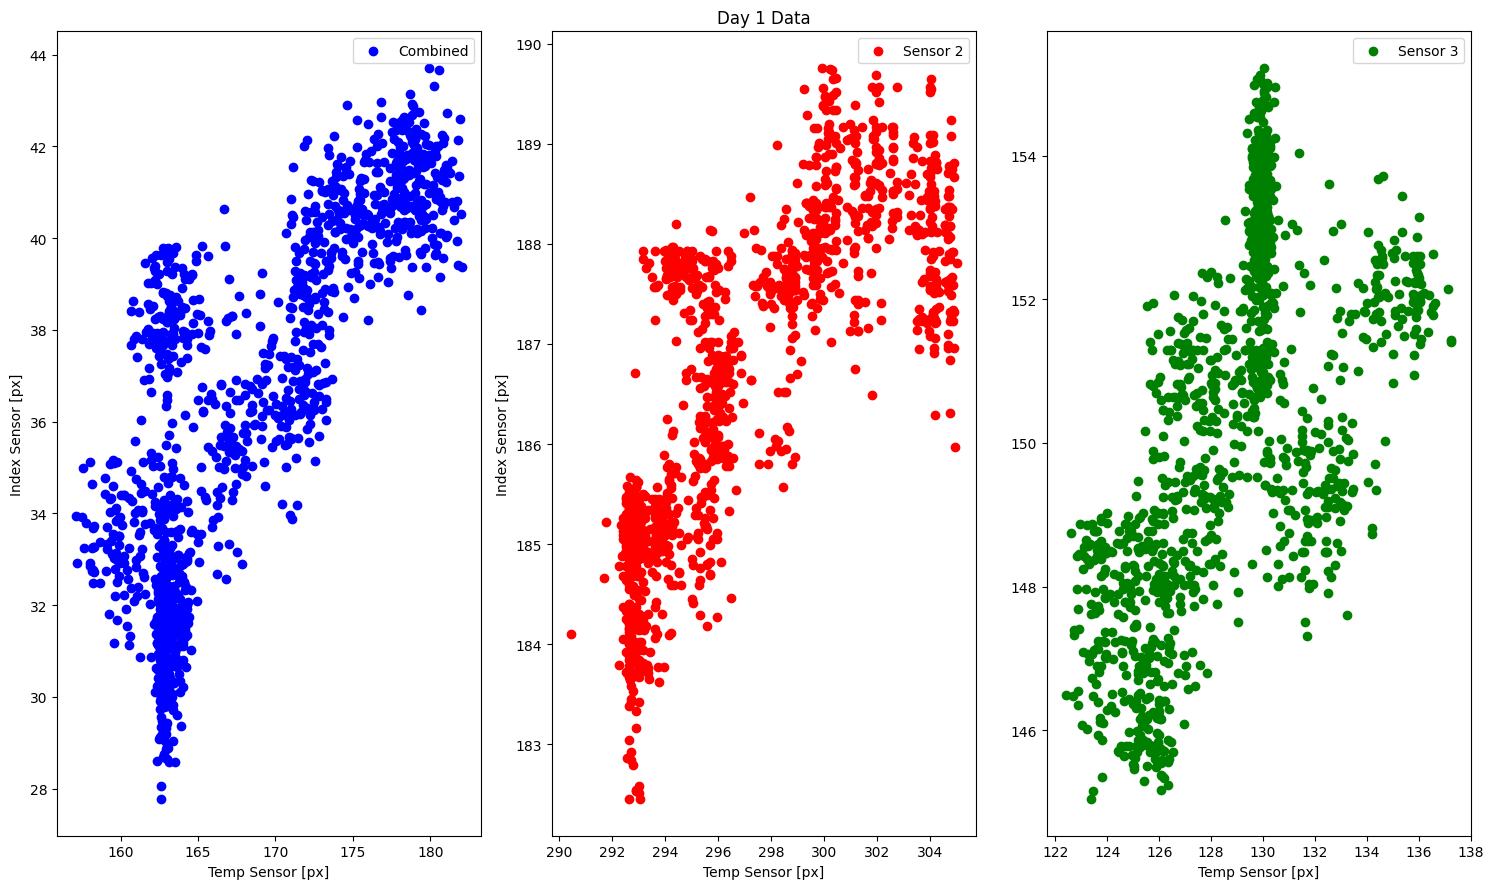

In [64]:
symmetrical_sensor = day1_data['sensor2'] - day1_data['sensor3']
symmetrical_temp = day1_data['temp2'] - day1_data['temp3']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[15, 9])
ax1.scatter(symmetrical_temp, symmetrical_sensor, color='b', label='Combined')
ax2.scatter(day1_data['temp2'], day1_data['sensor2'], color='r', label='Sensor 2')
ax3.scatter(day1_data['temp3'], day1_data['sensor3'], color='g', label='Sensor 3')
ax1.set_xlabel('Temp Sensor [px]')
ax1.set_ylabel('Index Sensor [px]')
ax2.set_xlabel('Temp Sensor [px]')
ax2.set_ylabel('Index Sensor [px]')
ax3.set_xlabel('Temp Sensor [px]')
ax4.set_ylabel('Index Sensor [px]')
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax2.set_title('Day 1 Data')
fig.tight_layout()
plt.show()

Now fit the correlation "polynomial", why does it ever need to be an order bigger than 1? That would require the temperature to vary drastically over a short time scale for 1 $\mu m$ of silica, is that possible?

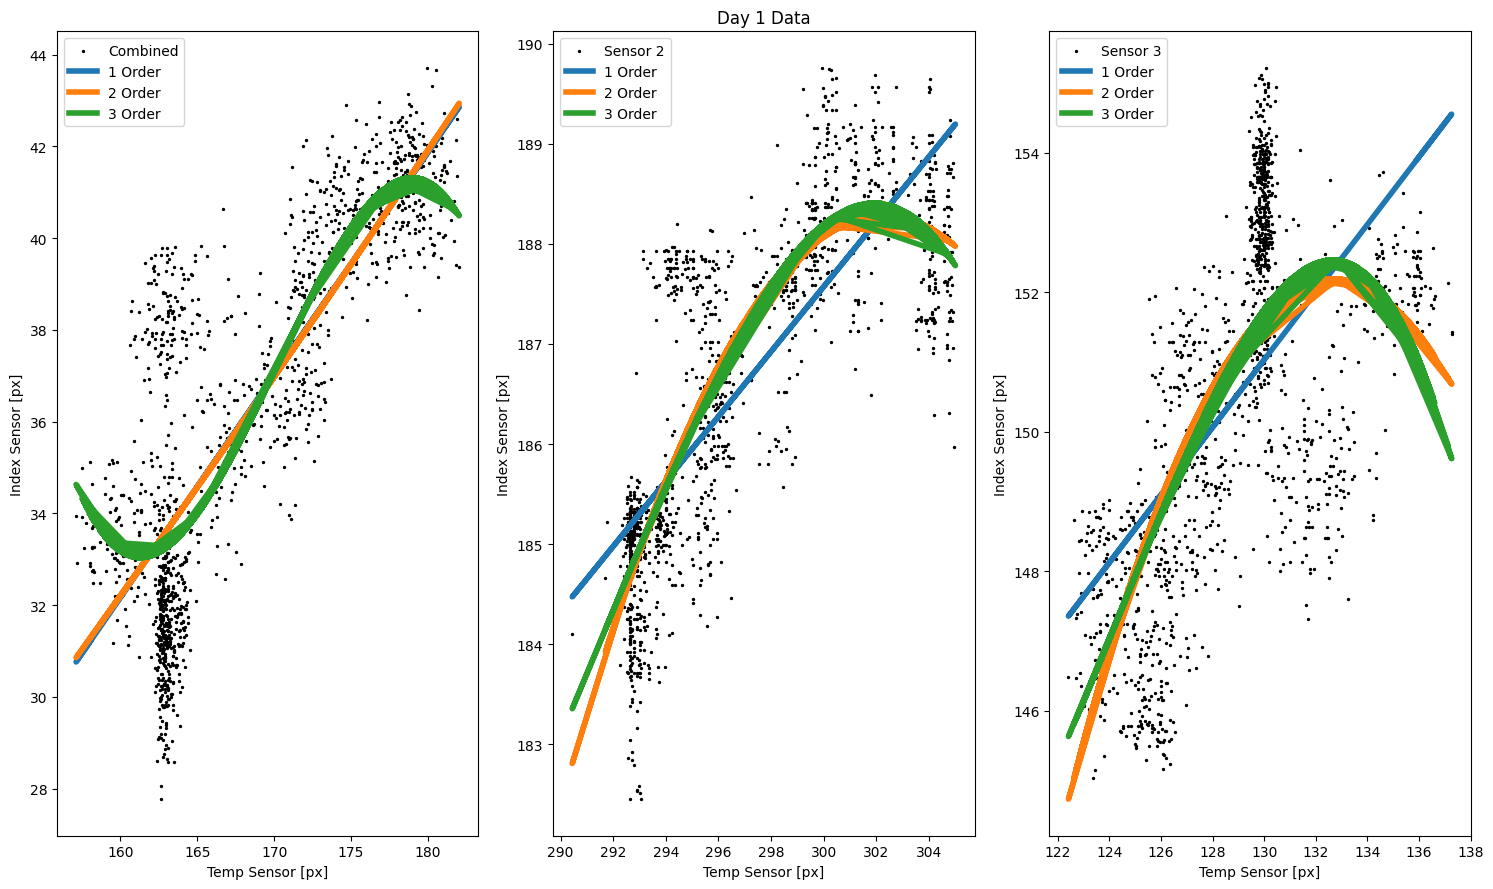

In [80]:
symmetrical_x = symmetrical_temp
symmetrical_y = symmetrical_sensor

x_2 = day1_data['temp2']
y_2 = day1_data['sensor2']

x_3 = day1_data['temp3']
y_3 = day1_data['sensor3']

symmetrical_fits = []
fits_2 = []
fits_3 = []

symmetrical_data = []
fulldata_2 = []
fulldata_3 = []

degrees = [1, 2, 3]
for degree in degrees:
    symmetrical_coefficients = np.polyfit(symmetrical_x, symmetrical_y, degree)
    coefficients_2 = np.polyfit(x_2, y_2, degree)
    coefficients_3 = np.polyfit(x_3, y_3, degree)

    symmetrical_polynomial = np.poly1d(symmetrical_coefficients)
    polynomial_2 = np.poly1d(coefficients_2)
    polynomial_3 = np.poly1d(coefficients_3)

    symmetrical_fit = symmetrical_polynomial(symmetrical_temp)
    fit_2 = polynomial_2(x_2)
    fit_3 = polynomial_3(x_3)

    symmetrical_fits.append(symmetrical_fit)
    fits_2.append(fit_2)
    fits_3.append(fit_3)

    symmetrical_full = symmetrical_polynomial(temp2 - temp3)
    full_2 = polynomial_2(temp2)
    full_3 = polynomial_3(temp3)

    symmetrical_data.append(symmetrical_full)
    fulldata_2.append(full_2)
    fulldata_3.append(full_3)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[15, 9])
ax1.scatter(symmetrical_temp, symmetrical_sensor, color='k', s=2, label='Combined')
ax2.scatter(day1_data['temp2'], day1_data['sensor2'], color='k', s=2, label='Sensor 2')
ax3.scatter(day1_data['temp3'], day1_data['sensor3'], color='k', s=2, label='Sensor 3')
ax1.set_xlabel('Temp Sensor [px]')
ax1.set_ylabel('Index Sensor [px]')
ax2.set_xlabel('Temp Sensor [px]')
ax2.set_ylabel('Index Sensor [px]')
ax3.set_xlabel('Temp Sensor [px]')
ax3.set_ylabel('Index Sensor [px]')
for index, fit in enumerate(symmetrical_fits):
    ax1.plot(symmetrical_temp, fit, f'C{index}', lw=4, label=f'{index+1} Order')
    ax2.plot(day1_data['temp2'], fits_2[index], f'C{index}', lw=4, label=f'{index+1} Order')
    ax3.plot(day1_data['temp3'], fits_3[index], f'C{index}', lw=4, label=f'{index+1} Order')
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax2.set_title('Day 1 Data')
fig.tight_layout()
plt.show()

Apply polynomial to full data sets.

C:\Users\jm1261\AppData\Local\Temp\ipykernel_24204\2953521943.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc=0)


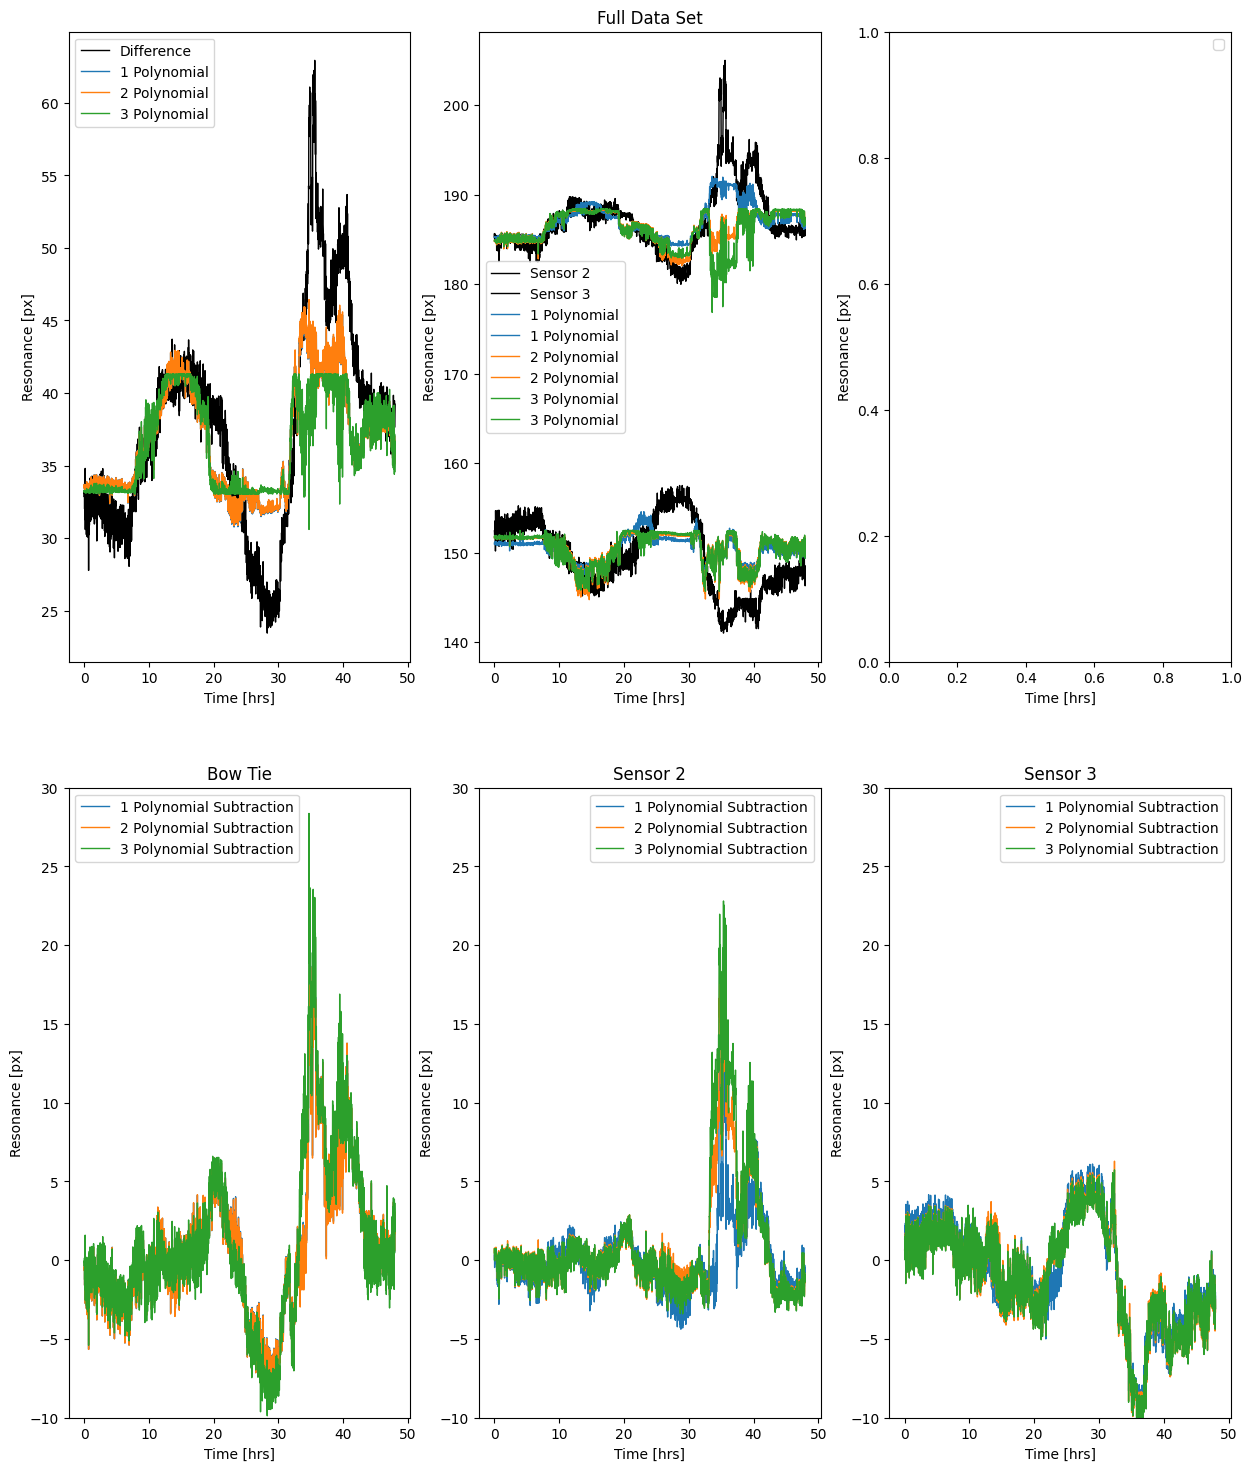

In [91]:
total_hours = total_time / (60 * 60)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=[15, 18])
ax1.plot(total_hours, sensor2 - sensor3, 'k', lw=1, label='Difference')
ax2.plot(total_hours, sensor2, 'k', lw=1, label='Sensor 2')
ax2.plot(total_hours, sensor3, 'k', lw=1, label='Sensor 3')
for index, polynomial in enumerate(symmetrical_data):
    ax1.plot(total_hours, polynomial, f'C{index}', lw=1, label=f'{index+1} Polynomial')
    ax2.plot(total_hours, fulldata_2[index], f'C{index}', lw=1, label=f'{index+1} Polynomial')
    ax2.plot(total_hours, fulldata_3[index], f'C{index}', lw=1, label=f'{index+1} Polynomial')

    ax4.plot(total_hours, (sensor2 - sensor3) - polynomial, f'C{index}', lw=1, label=f'{index+1} Polynomial Subtraction')
    ax5.plot(total_hours, sensor2 - fulldata_2[index], f'C{index}', lw=1, label=f'{index+1} Polynomial Subtraction')
    ax6.plot(total_hours, sensor3 - fulldata_3[index], f'C{index}', lw=1, label=f'{index+1} Polynomial Subtraction')
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
ax5.legend(loc=0)
ax6.legend(loc=0)
ax4.set_ylim(-10, 30)
ax5.set_ylim(-10, 30)
ax6.set_ylim(-10, 30)

ax1.set_xlabel('Time [hrs]')
ax2.set_xlabel('Time [hrs]')
ax3.set_xlabel('Time [hrs]')
ax4.set_xlabel('Time [hrs]')
ax5.set_xlabel('Time [hrs]')
ax6.set_xlabel('Time [hrs]')
ax1.set_ylabel('Resonance [px]')
ax2.set_ylabel('Resonance [px]')
ax3.set_ylabel('Resonance [px]')
ax4.set_ylabel('Resonance [px]')
ax5.set_ylabel('Resonance [px]')
ax6.set_ylabel('Resonance [px]')

ax2.set_title('Full Data Set')
ax4.set_title('Bow Tie')
ax5.set_title('Sensor 2')
ax6.set_title('Sensor 3')

plt.show()